## Problem Statement

### Business Context

The healthcare industry is rapidly evolving, with professionals facing increasing challenges in managing vast volumes of medical data while delivering accurate and timely diagnoses. The need for quick access to comprehensive, reliable, and up-to-date medical knowledge is critical for improving patient outcomes and ensuring informed decision-making in a fast-paced environment.

Healthcare professionals often encounter information overload, struggling to sift through extensive research and data to create accurate diagnoses and treatment plans. This challenge is amplified by the need for efficiency, particularly in emergencies, where time-sensitive decisions are vital. Furthermore, access to trusted, current medical information from renowned manuals and research papers is essential for maintaining high standards of care.

To address these challenges, healthcare centers can focus on integrating systems that streamline access to medical knowledge, provide tools to support quick decision-making, and enhance efficiency. Leveraging centralized knowledge platforms and ensuring healthcare providers have continuous access to reliable resources can significantly improve patient care and operational effectiveness.

**Common Questions to Answer**

1. **Critical Care Protocols:** "What is the protocol for managing sepsis in a critical care unit?"

2. **General Surgery:** "What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?"

3. **Dermatology:** "What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?"

4. **Neurology:** "What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?"


### Objective

As an AI specialist, your task is to develop a RAG-based AI solution using renowned medical manuals to address healthcare challenges. The objective is to **understand** issues like information overload, **apply** AI techniques to streamline decision-making, **analyze** its impact on diagnostics and patient outcomes, **evaluate** its potential to standardize care practices, and **create** a functional prototype demonstrating its feasibility and effectiveness.

### Data Description

The **Merck Manuals** are medical references published by the American pharmaceutical company Merck & Co., that cover a wide range of medical topics, including disorders, tests, diagnoses, and drugs. The manuals have been published since 1899, when Merck & Co. was still a subsidiary of the German company Merck.

The manual is provided as a PDF with over 4,000 pages divided into 23 sections.

## Installing and Importing Necessary Libraries and Dependencies

In [56]:
# Install required libraries
!pip install -q langchain_community==0.3.27 \
              langchain==0.3.27 \
              chromadb==1.0.15 \
              pymupdf==1.26.3 \
              tiktoken==0.9.0 \
              ragas==0.3.0 \
              datasets==4.0.0 \
              evaluate==0.4.5 \
              langchain_openai==0.3.30


In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Note**:
- After running the above cell, kindly restart the runtime (for Google Colab) or notebook kernel (for Jupyter Notebook), and run all cells sequentially from the next cell.
- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in ***this notebook***.

## Question Answering using LLM

> **Note 1:** When choosing between an open-source Hugging Face (HF) model and OpenAI’s proprietary model, base your decision on your specific needs. If you opt for a Hugging Face model, make sure to connect to a GPU to execute the code efficiently.

> **Note 2**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:
1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.
2. Switch to a different Google account and resume working on the project from there.
3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

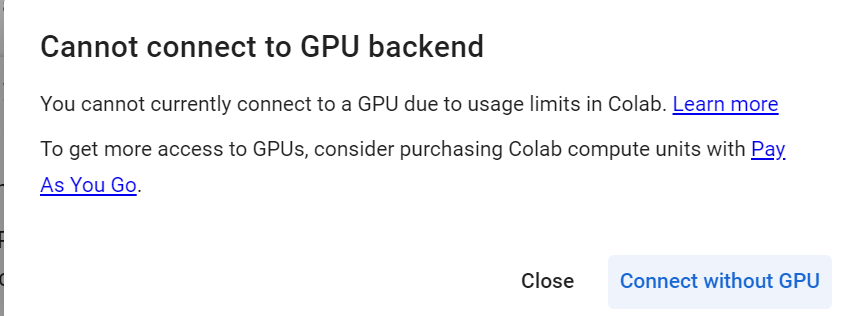

#### Downloading and Loading the model

In [58]:
# Import core libraries
import os                                                                       # Interact with the operating system (e.g., set environment variables)
import json                                                                     # Read/write JSON data

# Import libraries for working with PDFs and OpenAI
from langchain.document_loaders import PyMuPDFLoader                            # Load and extract text from PDF files
from openai import OpenAI                                                       # Access OpenAI's models and services

# Import libraries for processing dataframes and text
import tiktoken                                                                 # Tokenizer used for counting and splitting text for models
import pandas as pd                                                             # Load, manipulate, and analyze tabular data

# Import LangChain components for data loading, chunking, embedding, and vector DBs
from langchain.text_splitter import RecursiveCharacterTextSplitter              # Break text into overlapping chunks for processing
from langchain.embeddings.openai import OpenAIEmbeddings                        # Create vector embeddings using OpenAI's models  # type: ignore
from langchain.vectorstores import Chroma                                       # Store and search vector embeddings using Chroma DB  # type for ignore

# Import components to run evaluation on RAG pipeline outputs
from ragas import evaluate
from ragas.metrics import (
    Faithfulness,
    AnswerRelevancy,
    LLMContextPrecisionWithoutReference,
)
from datasets import Dataset                                                    # Used to structure the input (questions, answers, contexts etc.) in tabular format
from langchain_openai import ChatOpenAI

# Store API credentials in environment variables
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('open_api_token')                                          # Set API key as environment variable
os.environ["OPENAI_BASE_URL"] = userdata.get('open_api_base')                                 # Set API base URL as environment variable

# Initialize OpenAI client
client = OpenAI()

def generate_response(user_input,k=5,max_tokens=500,temperature=0.3,top_p=0.95):
    prompt="Answer the question"
    try:
        response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": prompt},
            {"role": "user", "content": user_input}
        ],
        max_tokens=max_tokens,
        temperature=temperature,
        top_p=top_p
        )
        # Extract and print the generated text from the response
        response = response.choices[0].message.content.strip()
    except Exception as e:
        response = f'Sorry, I encountered the following error: \n {e}'

    return response

### Question 1: What is the protocol for managing sepsis in a critical care unit?

In [59]:
question1 = "What is the protocol for managing sepsis in a critical care unit?"
base_answer_1=generate_response(question1)
print(base_answer_1)

The protocol for managing sepsis in a critical care unit typically involves the following steps:

1. Early recognition and diagnosis of sepsis: Prompt identification of sepsis is crucial for initiating timely treatment. This involves assessing the patient's clinical signs and symptoms, along with laboratory tests such as blood cultures and inflammatory markers.

2. Source control: Identifying and treating the source of infection is essential in sepsis management. This may involve procedures such as drainage of abscesses, debridement of infected tissue, or removal of infected devices.

3. Antibiotic therapy: Prompt administration of appropriate antibiotics is a cornerstone of sepsis treatment. Empiric broad-spectrum antibiotics are usually initiated initially and may be adjusted based on culture results and susceptibility testing.

4. Fluid resuscitation: Patients with sepsis often experience hypotension and hypoperfusion, requiring fluid resuscitation to restore adequate tissue perfusi

### Question 2: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?

In [60]:
question2 = "What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?"
base_answer_2=generate_response(question2)
print(base_answer_2)

Common symptoms of appendicitis include:

1. Sudden pain that starts near the navel and moves to the lower right abdomen
2. Nausea and vomiting
3. Loss of appetite
4. Fever
5. Abdominal swelling
6. Constipation or diarrhea
7. Inability to pass gas

Appendicitis is typically treated with surgery to remove the inflamed appendix, a procedure known as an appendectomy. In some cases, if the appendix has not ruptured and the infection is not severe, antibiotics may be used to treat the condition. However, surgery is the most common and effective treatment for appendicitis. If left untreated, appendicitis can lead to a ruptured appendix, which can be life-threatening.


### Question 3: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?

In [61]:
question3 = "What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?"
base_answer_3=generate_response(question3)
print(base_answer_3)

Sudden patchy hair loss, also known as alopecia areata, can be distressing but there are effective treatments available. Some possible causes of alopecia areata include genetics, autoimmune disorders, stress, and certain medical conditions. Here are some treatments and solutions for addressing sudden patchy hair loss:

1. Corticosteroid injections: Injecting corticosteroids into the bald patches can help stimulate hair growth by reducing inflammation and suppressing the immune response that is attacking the hair follicles.

2. Topical corticosteroids: Applying corticosteroid creams or ointments directly to the affected areas can also help reduce inflammation and promote hair regrowth.

3. Minoxidil: This over-the-counter medication is commonly used to treat male and female pattern baldness. It can also be effective in promoting hair growth in cases of alopecia areata.

4. Anthralin: This medication is applied to the scalp and can help to stimulate hair growth by irritating the skin and

### Question 4:  What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?

In [62]:
question4 = "What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?"
base_answer_4=generate_response(question4)
print(base_answer_4)

The recommended treatments for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function, will depend on the specific nature and severity of the injury. However, some common treatments and interventions may include:

1. Immediate medical care: This may involve stabilizing the patient, managing any bleeding or swelling in the brain, and ensuring proper oxygen supply to the brain.

2. Rehabilitation therapy: This can include physical therapy, occupational therapy, speech therapy, and cognitive therapy to help the individual regain lost functions and learn new ways to compensate for any permanent impairments.

3. Medications: Depending on the specific symptoms and complications of the brain injury, medications may be prescribed to manage pain, reduce inflammation, prevent seizures, or address other issues.

4. Surgery: In some cases, surgery may be necessary to remove blood clots, repair damaged tissue, or relieve pressu

## Question Answering using LLM with Prompt Engineering

Conduct experiment to fine better prompt tunning

In [63]:
def experiment_generate_response(system_prompt, user_input, k=5, max_tokens=700, temperature=0.2, top_p=0.9):
    """
    Variant of generate_response that accepts a system_prompt for prompt-tuning experiments.
    """
    try:
        resp = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_input}
            ],
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p
        )
        return resp.choices[0].message.content.strip()
    except Exception as e:
        return f"Error: {e}"

# Define five system-prompt variations (iterations).
prompt_variations = [
    {
        "name": "Iteration 1 - Baseline",
        "system_prompt": "Answer the question.",
        "note": "Baseline: short generic system prompt. Useful as control to measure improvements."
    },
    {
        "name": "Iteration 2 - Role + Evidence",
        "system_prompt": (
            "You are a board-certified critical care physician. Provide a clear, evidence-aware, "
            "step-by-step response. When giving clinical steps, be concise and cite guideline names "
            "(e.g., 'Surviving Sepsis Campaign') where appropriate. State uncertainty if present."
        ),
        "note": "Adds role and asks for guideline citations to increase clinical grounding."
    },
    {
        "name": "Iteration 3 - Structured timeline",
        "system_prompt": (
            "You are a critical care specialist. Answer as a structured checklist organized by time: "
            "Immediate (0-1 hr), Early (1-6 hrs), Ongoing (24+ hrs). For each item include action, "
            "rationale, and critical monitoring metrics (with thresholds). Keep each item 1-2 sentences."
        ),
        "note": "Structured timeline forces clear prioritization and measurable monitoring guidance."
    },
    {
        "name": "Iteration 4 - Safety + Limitations",
        "system_prompt": (
            "You are a senior ICU clinician. Provide a stepwise protocol and for each step list: action, "
            "key contraindications, and any data/values that would change the plan. If you lack enough "
            "information, explicitly say so and list what additional data is needed."
        ),
        "note": "Emphasizes safety, contraindications and explicit admission of uncertainty."
    },
    {
        "name": "Iteration 5 - Polished checklist with references (final candidate)",
        "system_prompt": (
            "You are a senior critical care physician producing a concise clinical checklist. Deliver: "
            "(1) A 6-10 step numbered protocol with time windows; (2) Key monitoring metrics and thresholds; "
            "(3) One-line rationale per step; (4) Common pitfalls/contraindications; (5) Suggested guideline references "
            "by name (no URLs). Be concise and clinical — final output should be directly usable by ICU staff."
        ),
        "note": "Combines structure, safety, and explicit references — intended final tuning."
    }
]

# The clinical question used for experiments (same as the selected block)
experiment_question = "What is the protocol for managing sepsis in a critical care unit?"

# Run experiments sequentially and print concise analysis and suggested tweak after each run.
experiment_results = []
for idx, pv in enumerate(prompt_variations, start=1):
    print(f"\n--- {pv['name']} ---")
    print(f"# Note: {pv['note']}\n")
    # Run the prompt variant
    out = experiment_generate_response(pv["system_prompt"], experiment_question)
    experiment_results.append({"name": pv["name"], "system_prompt": pv["system_prompt"], "output": out})
    # Print the LLM output (so user can inspect)
    print("Model output (truncated to 1200 chars):")
    print(out[:1200])
    # Short automated observations to guide user inspection
    print("\nObservation (automated):")
    if idx == 1:
        print("- Likely general / less structured. Use as baseline.")
        print("Suggested tweak: add role and ask for steps + citations to improve clinical grounding.")
    elif idx == 2:
        print("- More clinical tone and citations requested. Check if explicit steps and guideline names appear.")
        print("Suggested tweak: enforce timeline structure to improve prioritization.")
    elif idx == 3:
        print("- Expect clear time windows and monitoring metrics. Verify thresholds are present and concise.")
        print("Suggested tweak: add explicit contraindications and statements of uncertainty.")
    elif idx == 4:
        print("- Expect safety constraints and explicit 'I don't know' behavior when data missing.")
        print("Suggested tweak: combine timeline + safety + succinct checklist for final polish.")
    else:
        print("- Final candidate: should be concise checklist with times, monitoring, pitfalls, and references.")
        print("If output is satisfactory, this prompt will be used for downstream questions.")

    print("\nComment: changed system prompt to emphasize:", pv["note"])
    print("Proceeding to next iteration...\n")

# Decide best prompt (choose Iteration 5 as best candidate by design).
best_prompt = prompt_variations[-1]["system_prompt"]
print("\n=== Selected best tuning: Iteration 5 - Polished checklist with references ===\n")

# Define a tuned wrapper that uses the selected best prompt for subsequent Q/A.
def tuned_generate_response(user_input, max_tokens=700, temperature=0.2, top_p=0.9):
    return experiment_generate_response(best_prompt, user_input, max_tokens=max_tokens, temperature=temperature, top_p=top_p)



--- Iteration 1 - Baseline ---
# Note: Baseline: short generic system prompt. Useful as control to measure improvements.

Model output (truncated to 1200 chars):
The protocol for managing sepsis in a critical care unit typically involves the following steps:

1. Early recognition and diagnosis of sepsis: Prompt identification of sepsis is crucial for initiating timely treatment. This involves assessing the patient's clinical signs and symptoms, along with laboratory tests such as blood cultures and inflammatory markers.

2. Source control: Identifying and treating the source of infection, such as through surgical intervention or drainage of abscesses, is essential in managing sepsis.

3. Antibiotic therapy: Administering broad-spectrum antibiotics promptly is crucial to target the causative organism. Antibiotic therapy may be adjusted based on culture results and the patient's response.

4. Fluid resuscitation: Intravenous fluids are administered to maintain adequate perfusion and blo

### Question 1: What is the protocol for managing sepsis in a critical care unit?

In [64]:
prompt_answer_1 = tuned_generate_response(question1)
print(prompt_answer_1)

1. Within 1 hour of sepsis recognition:
   - Administer broad-spectrum antibiotics.
   Rationale: Early administration of antibiotics is crucial in improving outcomes in sepsis.

2. Within 3 hours of sepsis recognition:
   - Obtain blood cultures before antibiotic administration.
   Rationale: Blood cultures help identify the causative pathogen and guide targeted antibiotic therapy.

3. Within 6 hours of sepsis recognition:
   - Administer 30 ml/kg crystalloid for hypotension or lactate ≥4 mmol/L.
   Rationale: Early fluid resuscitation is essential to improve perfusion and oxygen delivery to tissues.

4. Monitor lactate levels every 2-4 hours.
   Threshold: Aim for normalization of lactate levels (<2 mmol/L).
   Rationale: Lactate levels are a marker of tissue hypoperfusion and response to resuscitation.

5. Maintain mean arterial pressure (MAP) ≥65 mmHg.
   Threshold: MAP <65 mmHg.
   Rationale: Adequate perfusion pressure is essential to prevent organ dysfunction.

6. Consider vasop

### Question 2: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?

In [65]:
prompt_answer_2 = tuned_generate_response(question2)
print(prompt_answer_2)

1. Clinical Checklist for Appendicitis Management:
   1. Assess patient for classic symptoms (e.g., right lower quadrant pain, anorexia, nausea, vomiting).
   2. Perform physical examination (e.g., McBurney's point tenderness, rebound tenderness).
   3. Order laboratory tests (e.g., CBC, CRP) and imaging studies (e.g., ultrasound, CT scan) within 1 hour.
   4. Administer IV fluids and broad-spectrum antibiotics (e.g., ceftriaxone + metronidazole) within 1 hour.
   5. Consult general surgery for urgent appendectomy within 6 hours.
   6. Monitor for signs of perforation (e.g., fever, worsening abdominal pain) and escalate care if suspected.

2. Key Monitoring Metrics:
   - WBC count: >10,000 cells/mm³
   - CRP level: >5 mg/L
   - Imaging findings consistent with appendicitis
   - Surgical consultation and appendectomy within recommended time frames

3. Rationale:
   - Timely diagnosis and surgical intervention are crucial to prevent complications like perforation and peritonitis.
   - An

### Question 3: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?

In [66]:
prompt_answer_3 = tuned_generate_response(question3)
print(prompt_answer_3)

1. **Assessment**: Perform a thorough physical examination and medical history within 24 hours of presentation to identify potential causes of patchy hair loss.
   - Rationale: Prompt assessment can help determine the underlying cause and guide appropriate treatment.

2. **Laboratory Investigations**: Order blood tests including complete blood count, thyroid function tests, and autoimmune markers within 48 hours.
   - Rationale: Identifying any underlying systemic conditions can help tailor treatment and management.

3. **Topical Corticosteroids**: Initiate high-potency topical corticosteroids (e.g., clobetasol) for localized alopecia areata within 72 hours.
   - Rationale: Topical corticosteroids have shown efficacy in promoting hair regrowth in cases of alopecia areata.

4. **Intralesional Corticosteroid Injections**: Consider intralesional corticosteroid injections (e.g., triamcinolone) for resistant or extensive alopecia areata within 1 week.
   - Rationale: Injections can be effec

### Question 4:  What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?

In [67]:
prompt_answer_4 = tuned_generate_response(question4)
print(prompt_answer_4)

1. **Assess and stabilize airway, breathing, and circulation within 5 minutes of injury:
   - Rationale: Ensure adequate oxygenation and perfusion to prevent secondary brain injury.
   - Pitfalls: Delay in securing airway or addressing hypotension can worsen outcomes.

2. **Perform neurological assessment and Glasgow Coma Scale (GCS) scoring every hour:
   - Rationale: Monitor for changes in neurological status that may indicate worsening brain injury.
   - Pitfalls: Missing subtle neurological changes that require intervention.

3. **Maintain intracranial pressure (ICP) <20 mmHg within 1 hour of injury:
   - Rationale: Elevated ICP can lead to further brain damage; manage with head elevation, sedation, osmotic therapy.
   - Pitfalls: Failure to control ICP can result in herniation and poor outcomes.

4. **Initiate seizure prophylaxis with antiepileptic drugs within 2 hours of injury:
   - Rationale: Prevent seizures that can exacerbate brain injury and increase metabolic demand.
   - 

## Data Preparation for RAG

### Loading the Data

In [68]:
pdf_path = "/content/drive/MyDrive/ML/medical_diagnosis_manual.pdf" # Path to the PDF document - Please ensure this file exists in your Google Drive at this path.
loader = PyMuPDFLoader(pdf_path)
docs = loader.load()

### Data Overview

In [69]:
# Display the number of pages loaded
print(f"Number of pages loaded: {len(docs)}")

# Display the content of the first page to verify
print("\nContent of the first page:\n")
print(docs[0].page_content[:1000]) # Print first 1000 characters of the first page

Number of pages loaded: 4114

Content of the first page:

lfravierl@gmail.com
18SG0XDVFA
meant for personal use by lfravierl@gma
shing the contents in part or full is liable


### Data Chunking

In [70]:
# Initialize the tokenizer for text splitting
tokenizer = tiktoken.get_encoding("cl100k_base")

# Define a function to count tokens
def tiktoken_len(text):
    tokens = tokenizer.encode(text)
    return len(tokens)

# Configure the text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
    length_function=tiktoken_len,
    separators=["\n\n", "\n", " ", ""]
)

# Split the documents into chunks
chunks = text_splitter.split_documents(docs)

# Display the number of chunks created
print(f"Number of chunks: {len(chunks)}")

# Display the content of the first chunk and its metadata to verify
print("\nContent of the first chunk:\n")
print(chunks[0].page_content[:500]) # Print first 500 characters of the first chunk

Number of chunks: 4667

Content of the first chunk:

lfravierl@gmail.com
18SG0XDVFA
meant for personal use by lfravierl@gma
shing the contents in part or full is liable


### Embedding

In [71]:
# Initialize OpenAIEmbeddings to create vector representations of the text chunks
embeddings = OpenAIEmbeddings(model="text-embedding-3-small", chunk_size=100) # Using a cost-effective and efficient embedding model, with chunk_size to manage API limits

# To verify the embedding dimensions, we can get a sample embedding
# Note: We won't embed all chunks here, as it's typically done directly when creating the vector store.
# This is just to demonstrate the embedding process.
if chunks:
    sample_text = chunks[0].page_content
    sample_embedding = embeddings.embed_query(sample_text)
    print(f"Generated a sample embedding for the first chunk. Dimension: {len(sample_embedding)}")
else:
    print("No chunks available to generate embeddings.")

Generated a sample embedding for the first chunk. Dimension: 1536


### Vector Database

In [72]:
# Create a Chroma vector database from the chunks and embeddings
vector_db = Chroma.from_documents(
    documents=chunks,
    embedding=embeddings,
)

print("Chroma vector database created successfully!")

Chroma vector database created successfully!


### Retriever

In [73]:
# Configure the vector database to act as a retriever
retriever = vector_db.as_retriever(search_kwargs={"k": 5}) # Retrieve top 5 relevant documents

print("Retriever implemented successfully!")

Retriever implemented successfully!


### Response Function

In [74]:
def response_function(user_input, k=5, max_tokens=500, temperature=0.3, top_p=0.95):
    # Retrieve relevant documents (chunks) based on the user's input
    retrieved_docs = retriever.invoke(user_input)

    # Extract the page content from the retrieved documents
    contexts = [doc.page_content for doc in retrieved_docs]

    # Combine the user's input with the retrieved contexts to create a comprehensive prompt
    rag_prompt = f"""Using the following information, answer the question. If the information is not sufficient, please state that you cannot answer based on the provided context.

    Contexts:
    {contexts}

    Question: {user_input}
    Answer:"""

    # Generate a response using the OpenAI client with the RAG prompt
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a helpful medical assistant that provides answers based on the given context."},
                {"role": "user", "content": rag_prompt}
            ],
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p
        )
        # Extract and return the generated text from the response along with the contexts
        return response.choices[0].message.content.strip(), contexts
    except Exception as e:
        return f'Sorry, I encountered the following error: \n {e}', [] # Return empty contexts in case of error

print("Response function defined successfully!")

Response function defined successfully!


## Question Answering using RAG

### Question 1: What is the protocol for managing sepsis in a critical care unit?

In [75]:
rag_answer_1, rag_contexts_1 = response_function("What is the protocol for managing sepsis in a critical care unit?")
print(rag_answer_1)

The protocol for managing sepsis in a critical care unit includes the following steps:

1. **Fluid Resuscitation**: Administer 0.9% normal saline until central venous pressure (CVP) reaches 8 mm Hg (10 cm H2O) or pulmonary artery occlusive pressure (PAOP) reaches 12 to 15 mm Hg. Oliguria with hypotension is not a contraindication to vigorous fluid resuscitation, and the quantity of fluid required may exceed normal blood volume, potentially reaching 10 L over 4 to 12 hours.

2. **Oxygen Therapy**: Provide oxygen via mask or nasal prongs. Tracheal intubation and mechanical ventilation may be necessary for respiratory failure.

3. **Broad-Spectrum Antibiotics**: Initiate broad-spectrum antibiotics promptly, modifying the regimen based on culture results once available. Antibiotics should be continued for at least 5 days after shock resolves and evidence of infection subsides.

4. **Drainage and Surgical Intervention**: Drain any abscesses and excise necrotic tissue as necessary to elimina

### Question 2: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?

In [76]:
rag_answer_2, rag_contexts_2 = response_function(question2)
print(rag_answer_2)

The common symptoms of appendicitis include:

- Epigastric or periumbilical pain that shifts to the right lower quadrant after a few hours
- Brief nausea and vomiting
- Anorexia
- Pain that increases with cough and motion
- Right lower quadrant direct and rebound tenderness (located at McBurney's point)
- Low-grade fever (rectal temperature 37.7 to 38.3° C [100 to 101° F])

It is noted that these classic findings appear in less than 50% of patients, and many variations of symptoms can occur, especially in infants, children, elderly patients, and pregnant women.

Appendicitis cannot be cured via medicine alone. The recommended surgical procedure for treating appendicitis is an appendectomy, which can be performed either as an open surgery or laparoscopically. This procedure involves the surgical removal of the appendix.


### Question 3: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?

In [77]:
rag_answer_3, rag_contexts_3 = response_function(question3)
print(rag_answer_3)

The effective treatments for sudden patchy hair loss, commonly referred to as alopecia areata, include:

1. **Topical Corticosteroids**: These are often used to reduce inflammation and promote hair regrowth in affected areas.
2. **Intralesional Corticosteroids**: Injections of corticosteroids directly into the bald spots can be effective for localized alopecia areata.
3. **Systemic Corticosteroids**: In severe cases, systemic corticosteroids may be prescribed.
4. **Topical Minoxidil**: This treatment can help stimulate hair growth.
5. **Topical Anthralin**: A medication that can help in the treatment of alopecia areata.
6. **Topical Immunotherapy**: Agents like diphencyprone or squaric acid dibutylester may be used to provoke an allergic reaction that can stimulate hair regrowth.
7. **Psoralen plus Ultraviolet A (PUVA)**: This treatment combines a medication with ultraviolet light therapy.

Possible causes of sudden patchy hair loss (alopecia areata) include:

- **Autoimmune Disorders*

### Question 4:  What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?

In [78]:
rag_answer_4, rag_contexts_4 = response_function(question4)
print(rag_answer_4)

The recommended treatments for a person who has sustained a physical injury to brain tissue (traumatic brain injury, TBI) include:

1. **Initial Management**:
   - Ensure a reliable airway and maintain adequate ventilation, oxygenation, and blood pressure.
   - Surgery may be needed for severe injuries to monitor and treat intracranial pressure, decompress the brain if necessary, or remove intracranial hematomas.

2. **Monitoring**:
   - Frequent recording of neurologic findings (Glasgow Coma Scale, pupillary reaction), blood pressure, pulse, and temperature for several hours after initial evaluation, as any deterioration requires prompt attention.

3. **Treatment of Complications**:
   - Address complications such as increased intracranial pressure (ICP), seizures, and hematomas.

4. **Rehabilitation**:
   - When neurologic deficits persist, rehabilitation is necessary, ideally through a team approach that includes physical, occupational, and speech therapy, as well as counseling for 

## Output Evaluation

#### **Evaluation 1: Base Prompt Response Evaluation**

In [79]:
questions = [question1, question2, question3, question4]
answers = [base_answer_1, base_answer_2, base_answer_3, base_answer_4]
base_rows = []
for i, (question, answer) in enumerate(zip(questions, answers), start=1):
    # Create a dataset for Ragas evaluation
    eval_dataset = Dataset.from_dict({
        'question': [question],
        'answer': [answer],
        'contexts': [[]],  # No retrieved contexts for base prompt evaluation
        'ground_truth': ['']  # No ground truth provided for this baseline
    })

    # Define the metrics to be used for evaluation
    metrics = [
        Faithfulness(),
        AnswerRelevancy(),
        LLMContextPrecisionWithoutReference()
    ]

    # Evaluate the answer
    print(f"Evaluating Base Answer {i}...")
    result = evaluate(
        dataset=eval_dataset,
        metrics=metrics,
        llm=ChatOpenAI(model="gpt-4o-mini"),
        embeddings=embeddings
    )

    # Serialize result to JSON-compatible structure and append as a row
    try:
        result_json = json.loads(json.dumps(result, default=lambda o: getattr(o, '__dict__', str(o))))
    except Exception:
        result_json = {"raw_result": str(result)}

    base_rows.append({
        "question_id": f"question_{i}",
        "reponse_type": "base",
        "faithfulness": result_json.get("scores", [{}])[0].get("faithfulness"),
        "answer_relevancy": result_json.get("scores", [{}])[0].get("answer_relevancy"),
        "context_precision": result_json.get("scores", [{}])[0].get("llm_context_precision_without_reference")
    })

# Create a DataFrame
eval_base_df = pd.DataFrame(base_rows)
print("Created eval_base_df with shape:", eval_base_df.shape)
print(eval_base_df.head())

Evaluating Base Answer 1...


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating Base Answer 2...


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating Base Answer 3...


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating Base Answer 4...


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Created eval_base_df with shape: (4, 5)
  question_id reponse_type  faithfulness  answer_relevancy  context_precision
0  question_1         base      0.000000          0.880144                0.0
1  question_2         base      0.000000          0.722404                0.0
2  question_3         base      0.032258          0.797529                0.0
3  question_4         base      1.000000          0.000000                0.0


#### **Evaluation 2: Prompt Engineering Response Evaluation**

In [80]:
answers_costar = [prompt_answer_1, prompt_answer_2, prompt_answer_3, prompt_answer_4]
base_rows = []

for i, (question, answer) in enumerate(zip(questions, answers_costar), start=1):
  # Create a dataset for Ragas evaluation
  eval_dataset = Dataset.from_dict({
      'question': [question],
      'answer': [answer],
      'contexts': [[]],  # No retrieved contexts for base prompt evaluation
      'ground_truth': ['']  # No ground truth provided for this baseline
  })

  # Define the metrics to be used for evaluation
  metrics = [
      Faithfulness(),
      AnswerRelevancy(),
      LLMContextPrecisionWithoutReference()
  ]

  # Evaluate the answer
  print(f"Evaluating Prompt Answer {i}...")
  result = evaluate(
      dataset=eval_dataset,
      metrics=metrics,
      llm=ChatOpenAI(model="gpt-4o-mini"),
      embeddings=embeddings
  )

  # Serialize result to JSON-compatible structure and append as a row
  try:
      result_json = json.loads(json.dumps(result, default=lambda o: getattr(o, '__dict__', str(o))))
  except Exception:
      result_json = {"raw_result": str(result)}

  base_rows.append({
      "question_id": f"question_{i}",
      "reponse_type": "prompt",
      "faithfulness": result_json.get("scores", [{}])[0].get("faithfulness"),
      "answer_relevancy": result_json.get("scores", [{}])[0].get("answer_relevancy"),
      "context_precision": result_json.get("scores", [{}])[0].get("llm_context_precision_without_reference")
  })

# Create a DataFrame
eval_prompt_df = pd.DataFrame(base_rows)
print("Created eval_prompt_df with shape:", eval_prompt_df.shape)
print(eval_prompt_df.head())

Evaluating Prompt Answer 1...


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating Prompt Answer 2...


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating Prompt Answer 3...


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating Prompt Answer 4...


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Created eval_prompt_df with shape: (4, 5)
  question_id reponse_type  faithfulness  answer_relevancy  context_precision
0  question_1       prompt           0.0          0.741192                0.0
1  question_2       prompt           1.0          0.584668                0.0
2  question_3       prompt           0.0          0.684730                0.0
3  question_4       prompt           0.0          0.620571                0.0


#### **Evaluation 3: RAG Response Evaluation**

In [81]:
answers_rag = [rag_answer_1, rag_answer_2, rag_answer_3, rag_answer_4]
contexts_rag = [rag_contexts_1, rag_contexts_2, rag_contexts_3, rag_contexts_4]

base_rows = []
# Define metrics once
metrics_rag = [
    Faithfulness(),
    AnswerRelevancy(),
    LLMContextPrecisionWithoutReference()
]

# Loop through each question, answer, and context
for i, (question, answer, context) in enumerate(zip(questions, answers_rag, contexts_rag), start=1):
    # Create dataset for RAG evaluation
    eval_dataset = Dataset.from_dict({
        'question': [question],
        'answer': [answer],
        'contexts': [context],
        'ground_truth': ['']  # No ground truth provided
    })

    print(f"Evaluating RAG Answer {i}...")
    result = evaluate(
        dataset=eval_dataset,
        metrics=metrics_rag,
        llm=ChatOpenAI(model="gpt-4o-mini"),
        embeddings=embeddings
    )

    # Serialize result to JSON-compatible structure and append as a row
    try:
        result_json = json.loads(json.dumps(result, default=lambda o: getattr(o, '__dict__', str(o))))
    except Exception:
        result_json = {"raw_result": str(result)}

    base_rows.append({
        "question_id": f"question_{i}",
        "reponse_type": "rag",
        "faithfulness": result_json.get("scores", [{}])[0].get("faithfulness"),
        "answer_relevancy": result_json.get("scores", [{}])[0].get("answer_relevancy"),
        "context_precision": result_json.get("scores", [{}])[0].get("llm_context_precision_without_reference")
    })

# Create a DataFrame
eval_rag_df = pd.DataFrame(base_rows)
print("Created eval_rag_df with shape:", eval_rag_df.shape)
print(eval_rag_df.head())

Evaluating RAG Answer 1...


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating RAG Answer 2...


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating RAG Answer 3...


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating RAG Answer 4...


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Created eval_rag_df with shape: (4, 5)
  question_id reponse_type  faithfulness  answer_relevancy  context_precision
0  question_1          rag           1.0          0.937334                1.0
1  question_2          rag           1.0          0.618011                1.0
2  question_3          rag           1.0          0.789813                1.0
3  question_4          rag           1.0          0.826753                1.0


In [82]:
# Concat dataframes
combined = pd.concat([eval_base_df, eval_prompt_df, eval_rag_df], ignore_index=True, sort=True)
combined_sorted = combined.sort_values(by=['answer_relevancy','faithfulness'], ascending=False)
print(combined_sorted)

    answer_relevancy  context_precision  faithfulness question_id reponse_type
8           0.937334                1.0      1.000000  question_1          rag
0           0.880144                0.0      0.000000  question_1         base
11          0.826753                1.0      1.000000  question_4          rag
2           0.797529                0.0      0.032258  question_3         base
10          0.789813                1.0      1.000000  question_3          rag
4           0.741192                0.0      0.000000  question_1       prompt
1           0.722404                0.0      0.000000  question_2         base
6           0.684730                0.0      0.000000  question_3       prompt
7           0.620571                0.0      0.000000  question_4       prompt
9           0.618011                1.0      1.000000  question_2          rag
5           0.584668                0.0      1.000000  question_2       prompt
3           0.000000                0.0      1.00000

## Actionable Insights and Business Recommendations

### Summary insights

* RAG is the clearest winner: mean faithfulness ≈ 0.96, answer relevancy ≈ 0.81, LLM-context precision ≈ 0.98. RAG reliably grounds outputs in retrieved docs.
* Prompt engineering improves relevancy vs. Base (mean relevancy ≈ 0.80 vs 0.61) and has moderate faithfulness (≈ 0.72), but provides no contextual grounding (context precision = 0).
* Base prompt has no contextual grounding (context precision = 0), uneven relevancy (mean ≈ 0.61) and mixed faithfulness (≈ 0.50); one question returned 0 relevancy.
* RAG yields consistent gains on faithfulness and grounding across questions; relevancy improvements vs Prompting are small but consistent.

### Actionable recommendations

* Prioritize RAG for production: use retrieval grounding as primary safety/accuracy mechanism.
* Keep prompt engineering: use prompts as a fallback or to boost relevancy when retrieval is weak.
* Add a retrieval-quality check and fallback: if context precision is low or retriever returns poor matches, require alert/human review or switch to prompting fallback.
* Monitor three metrics in deployment: faithfulness, answer relevancy, and context precision; trigger human-in-loop on thresholds (e.g., faithfulness < 0.8 or context precision < 0.7).
* Maintain and curate the knowledge base (Merck Manuals etc.) and re-run automated evaluations after content updates.
* Institute clinician audits for high-risk queries and log source passages with every RAG answer for traceability.

<font size=6 color='#4682B4'>Power Ahead</font>
___

In [83]:
# Install nbconvert if it's not already installed
!pip install -q nbconvert

In [84]:
# Make sure 'notebook_name' variable is correctly set to your notebook's actual name, e.g., 'Medical_assistant_Full_Code_v2.ipynb'
# If the previous execution of this cell set it to 'Untitled0.ipynb', ensure that's what you want to convert.
notebook_name = '/content/drive/MyDrive/ML/Medical_assistant_Full_Code_v2.ipynb' # Corrected to the full absolute path

# Convert the notebook to HTML using the 'basic' template as a workaround for rendering issues
!jupyter nbconvert "$notebook_name" --to html

[NbConvertApp] Converting notebook /content/drive/MyDrive/ML/Medical_assistant_Full_Code_v2.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/jupyter_core/application.py", line 284, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/nbconvert/nbconvertapp.py", line 420, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.12/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python3.12/dist-packages/nbconvert/nbconvertapp.py", line 563, in convert_single_notebook
    output, resources = self.export_single_notebook(
                      